In [12]:
import os
import json
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def scene_date_from_filename(fname):
    """Extract scene acquisition date from filename."""
    import re

    m = re.search(r"_(\d{8})_", fname)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d").date()
    return None

In [3]:
def read_band(band_path):
    """Read raster band as float32 array."""
    with rasterio.open(band_path) as src:
        arr = src.read(1).astype("float32")
        profile = src.profile
    return arr, profile

In [4]:
def compute_lst(b10_arr, mult=0.00341802, add=149.0):
    """
    Convert ST_B10 scaled values to LST in Celsius.
    """
    lst_kelvin = b10_arr * mult + add
    lst_c = lst_kelvin - 273.15
    return lst_c

In [5]:
def mean_index_in_aoi(index_arr, profile, aoi_geojson):
    stats = zonal_stats(
        aoi_geojson,
        index_arr,
        affine=profile["transform"],
        stats=["mean", "median", "count", "std"],
        nodata=np.nan,
    )
    return stats[0]

In [6]:
def process_scene_folder_lst(scene_folder, aoi_geojson):
    """
    Process a single scene folder to compute LST statistics over the AOI.
    """
    b10_file = next(p for p in os.listdir(scene_folder) if "_ST_B10" in p)
    b10_arr, prof = read_band(os.path.join(scene_folder, b10_file))

    lst_arr = compute_lst(b10_arr)

    # Reproject AOI to raster CRS
    gdf = gpd.GeoDataFrame.from_features(aoi_geojson["features"], crs="EPSG:4326")
    gdf_utm = gdf.to_crs(prof["crs"])
    aoi_geojson_utm = gdf_utm.__geo_interface__

    stats = mean_index_in_aoi(lst_arr, prof, aoi_geojson_utm)

    scene_date = datetime.strptime(
        b10_file.split("_")[3], "%Y%m%d"
    ).date()  # extract date from filename

    return {
        "date": scene_date,
        "lst_mean": stats["mean"],
        "lst_median": stats["median"],
        "count": stats["count"],
        "lst_std": stats["std"],
    }

In [7]:
def build_timeseries_lst(data_root, aoi_geojson):
    """
    Build LST time series for all scenes in data_root.
    """
    rows = []
    for year in os.listdir(data_root):
        ypath = os.path.join(data_root, year)
        if not os.path.isdir(ypath):
            continue
        for month in os.listdir(ypath):
            mpath = os.path.join(ypath, month)
            if not os.path.isdir(mpath):
                continue
            try:
                r = process_scene_folder_lst(mpath, aoi_geojson)
                rows.append(r)
            except StopIteration:
                continue
    df = pd.DataFrame(rows).dropna().sort_values("date").reset_index(drop=True)
    return df

In [8]:
data_root = "../data"
aoi_geojson_path = "../data/aoi.geojson"

with open(aoi_geojson_path) as f:
    aoi_geojson = json.load(f)

In [9]:
df = build_timeseries_lst(data_root, aoi_geojson)
df.head()

,date,lst_mean,lst_median,count,lst_std
0,2022-02-12,13.168478,13.626984,2649889,4.372898
1,2022-03-08,25.446898,25.754120,2649889,3.893588
2,2022-04-17,31.615350,32.005646,2649889,4.400812
3,2022-05-27,27.281529,27.921112,2649889,4.171977
4,2022-10-18,22.788761,22.821442,2649889,3.496320


In [10]:
# Assuming df is your LST dataframe
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

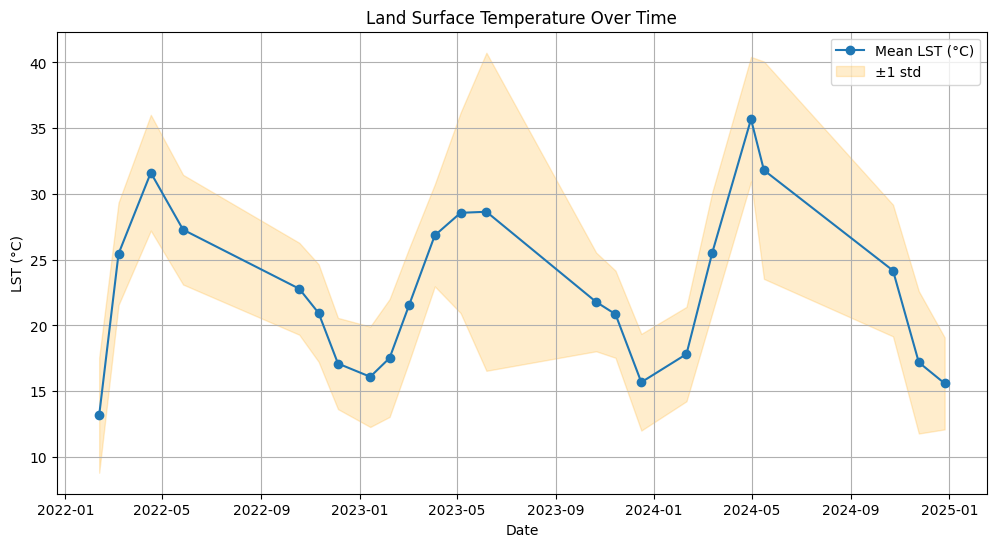

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["lst_mean"], marker="o", label="Mean LST (°C)")
plt.fill_between(
    df["date"],
    df["lst_mean"] - df["lst_std"],
    df["lst_mean"] + df["lst_std"],
    color="orange",
    alpha=0.2,
    label="±1 std",
)
plt.title("Land Surface Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("LST (°C)")
plt.grid(True)
plt.legend()
plt.show()


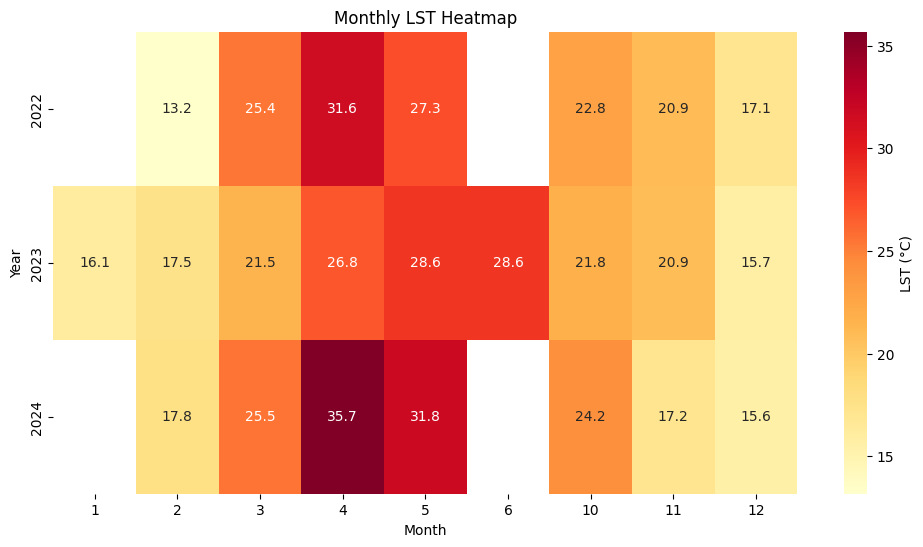

In [14]:
# Pivot table: rows=year, columns=month, values=mean LST
heatmap_df = df.pivot_table(index="year", columns="month", values="lst_mean")

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={"label": "LST (°C)"}
)
plt.title("Monthly LST Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()
